# How to train supervised machine learning algorithms **without** labeled data?

# Introduction

> *Garbage in, Garbage out!*  
  
There is a reason why this expression is so popular within the data science community.  
The very first step of any data science project, or machine learning design is to **get quality data**. This is performed using different tools, including web scraping, polls, measures from sensors, etc. The data is divided into two parts: **Features** and **Labels**. Features are the inputs of the machine learning algorithm. They will be used to predict the labels after the training process. During the training step (in supervised learning), the algorithm adapts gradually its parameters so the outputs resemble the provided labels.  
One of the most costly things in data collection is labeling. It involves usually human manipulation or annotation. Machine learning (and deep learning) algorithms require **large amount** of data to perform optimal training and be able to generalize. This prevent also **overfitting** to happen.  
  
## But what if the data is not labeled?  
When the data is missing a part or all labels, it is virtually impossible to perform supervised training. We must find a way to create targets, using one of the following approaches:
- Manual labeling: performed by experts, in-house data labelers, or using crowdsouring (like Amazon Mechanical Turk)
- Automated labeling: before training the ML algorithm, labels are created using unsupervised training techniques.  

In practice, the amount of required data to train efficiently deep learning algorithms is increasing. Requiring 50k, 100k or millions of labeled data points is not unusual in computer vision or natural language processing. We could combine the two approaches, in order to save on costs.  
## Label creation using deep autoencoders
In this article, we will go through the implementation of a labeling process, based on deep autoencoders. This unsupervised (or self-supervised) learning technique aims to learn the data structure by trying to regenerate the data. An autoencoder consists of two parts: encoder and decoder.
<p align="center"> <img src="https://i.imgur.com/1C0bFbG.png"> </p>   


The *encoder* part transforms the input data (the features) into a representation (called also an encoding) via multiple non-linear transformations. The trick is that the network learns at the same time, the inverse transformation in order to reconstruct the data from its representation. The inverse transformation is the *decoder*. When the autoencoder is trained properly, the data structure is **learned**. We could use the encoder then to generate labels, by replacing the decoder by a simple classifier that we train on the available labels.

<p align="center"> <img src="https://i.imgur.com/GvjSbwc.png"> </p>   
  
This technique requires some labels. As we will see later, we only need a fraction of labels that can be obtained manually or via crowdsourcing for a much lower cost. 

In [1]:
#import libraries and setup 
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import logging
logging.getLogger('tensorflow').disabled = True
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, UpSampling2D
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=10, restore_best_weights=True)
from sklearn.ensemble import RandomForestClassifier as clf


# The MNIST dataset

In this article, we will use the **MNIST** dataset to experiment with the efficiency of autoencoders in label creation. The **MNIST** dataset is a large database of handwritten digits and corresponding numbers. It contains 60000 grayscale images for training and 10000 images for validation/testing. It is considered as the *Hello World* of computer vision machine learning. This dataset can be obtained via multiple sources. We will use **Tensorflow/Keras** datasets to load the data.


In [2]:
# import mnist
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print(x_train.shape,y_train.shape)

(60000, 28, 28) (60000,)


The `x_train` tensor contains 60000 matrices of dimension 28x28. Each element of these matrices represents the brightness of a single pixel. The `y_train` tensor contains the labels for each image. We start by normalizing the data and reshaping the matrices to a format that can be used by `matplotlib` for visualization. A one hot encoding will be performed as well, on the labels. This will be used later during the validation/testing.

In [3]:
#normalize data
if x_train.max() >1:
    x_train = x_train / 255
    x_test = x_test / 255

default_shape = x_train.shape
#reshape input data to 1 channel
x_train = x_train.reshape(-1,default_shape[1],default_shape[2],1)
x_test = x_test.reshape(-1,default_shape[1],default_shape[2],1)
image_dim = x_train.shape[1:]

# one hot encoding labels
y_train_cat = to_categorical(y_train)
y_test_cat= to_categorical(y_test)

Let's show a random sample from the data:

Label = 9 


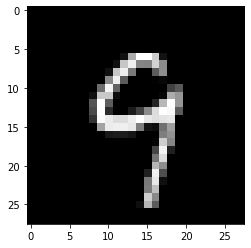

In [4]:
random_label = np.random.randint(0,59999)
plt.imshow(x_train[random_label,:,:], cmap='gray')
print('Label = {} '.format(y_train[random_label]))

The images are in low resolution (28x28). Since they are handwritten, many variations of the same digit can be encountered. The ML algorithm will need a lot of data points to be able to generalize!

# Design and validation of a data labeling process

In this section, we will implement data labeling process, based on a deep autoencoder. The method is described in the following diagram:  

<p align="center"> <img src="https://i.imgur.com/ur1rwG7.png"> </p>  
  
**- First (the middle column)** we will train a random forest classifier using all the training dataset, in order to set a reference for comparison.  
**- In the second step (the right column)** a similar classifier will be trained on a fraction of the data (in this article 1%). The goal is to quantify the impact of the dataset size on the overall classifier performance.  
**- Lastly** (the left column)** a data labeling process will be used to generate labels and train a classifier. We will compare the performance to the two previous implementations.    

## Random forest classifier training using the entire dataset

Using *Scikit learn*, we can implement a random forest classifier. No hyperparameter tuning will be performed. 

In [5]:
# create a classifier on all the data
classifier_all_labels= clf()
classifier_all_labels.fit(x_train.reshape(-1,28*28),y_train_cat)

RandomForestClassifier()

After the training step, we measure the average accuracy of the classifier on the *test* data.

In [6]:
#score of the classifier
classifier_all_labels.score(x_test.reshape(-1,28*28),y_test_cat)

0.9023

Not bad! 90% of accuracy using a classic machine learning approach on a computer vision problem is reasonable. We could obtain better results using deep learning and convolutional nets, but this is not the scope of this article.  
Here are some predictions on the *test* data:

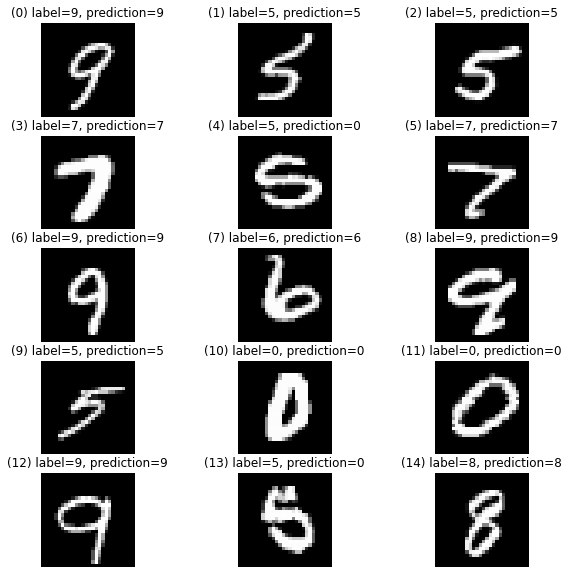

In [7]:
# a test on random images
random_labels = np.random.randint(0,9999,15)
img_samples = x_test[random_labels,:,:,:]
label_samples = y_test[random_labels]
plt.figure(figsize=(10, 10));
for i in range(15):
    plt.subplot(5,3,i+1)
    image = img_samples[i]
    pred = classifier_all_labels.predict(image.reshape(-1,28*28))
    plt.imshow(image, cmap='gray');
    plt.title('({}) label={}, prediction={}'.format(i,label_samples[i],np.argmax(pred)));
    plt.axis('off');

The classifier is able to predict the labels in most of the cases.  
The next step consists of training a similar architecture classifier, with less training data.

## Random forest classifier training using a fraction of the dataset

Let's suppose that **MNIST** doesn't provide labels with the images. If we have to create targets manually, we will have to repeat 60000 times this operation!  
If we assume that, overall, it takes 5 seconds per image to open the file, and record the label, the operation will require more than 83 hours... *there must be a better way!*  
In this article, we will label manually 1% of the data. 600 labels will take less than one hour to create. 

In [8]:
# what if we don't have all the labels
#split the training data into labeled and non labeled
labeled_ratio = 0.01 # 
labeled_index = np.int(len(x_train)*labeled_ratio)
x_train_labeled = x_train[:labeled_index]
x_train_unlabeled = x_train[labeled_index:]
y_train_cat_labeled = y_train_cat[:labeled_index] 
print('Number of labeled data points {} out of {}'.format(labeled_index,x_train.shape[0]))


Number of labeled data points 600 out of 60000


Let's see now, what performance we can get when training the random forest classifier on 1% of the data.

In [9]:
# what if the same model is trained only on a small part of data
classifier_few_labels =  clf()
classifier_few_labels.fit(x_train_labeled.reshape(-1,28*28),y_train_cat_labeled)

RandomForestClassifier()

In [10]:
#score of the classifier
classifier_few_labels.score(x_test.reshape(-1,28*28),y_test_cat)

0.4623

The score dropped from 90% to 47%. The classifier is simply useless in this case.

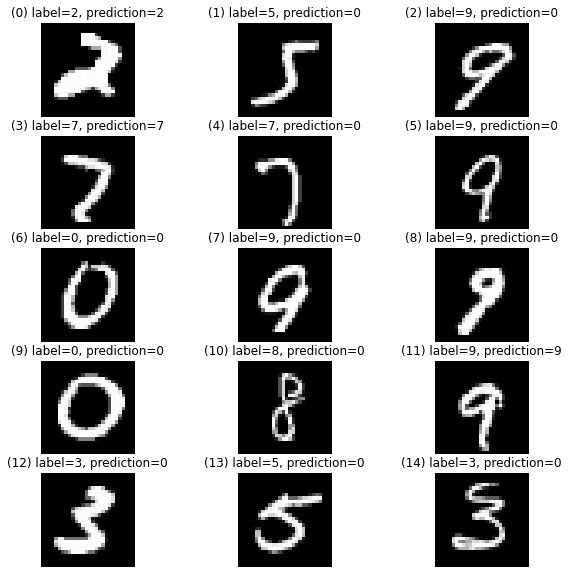

In [11]:
# a test on random images
random_labels = np.random.randint(0,9999,15)
img_samples = x_test[random_labels,:,:,:]
label_samples = y_test[random_labels]
plt.figure(figsize=(10, 10));
for i in range(15):
    plt.subplot(5,3,i+1)
    image = img_samples[i]
    pred = classifier_few_labels.predict(image.reshape(-1,28*28))
    plt.imshow(image, cmap='gray');
    plt.title('({}) label={}, prediction={}'.format(i,label_samples[i],np.argmax(pred)));
    plt.axis('off');

The predictions are not correct in most cases. We have to come up with more labels.

## Autoencoder design using convolutional neural networks

The training of autoencoder for label generation is divided into two steps:  
<p align="center"> <img src="https://i.imgur.com/Beq3wu3.png"> </p>   
We train initially the encoder and the decoder on the features, to learn data structure. After that, the decoder is replaced by a classification layer. The resulting system (encoder+classification layer) is trained on the available labels (1% in our case). During the training, only the classification layer's weights are optimized. In fact, the encoder is already trained and doesn't require further learning. Since the classification layer is not complex, we could obtain good results using a small fraction of labels.


We use deep convolutional networks to build the encoder. These neural networks are suitable for image data because they extract the useful features and are robust against shifting patterns. They require less parameters than dense networks.

In [12]:
# create an autoencoder / decoder on the whole data (without labels)
encoder = Sequential()
encoder.add(Conv2D(32,kernel_size=(3,3), strides=(1,1),padding='same', activation='selu',input_shape=image_dim))
encoder.add(MaxPooling2D(2,2))
encoder.add(Conv2D(64,kernel_size=(3,3), strides=(1,1),padding='same',activation='selu'))
encoder.add(MaxPooling2D(2,2))
encoder.add(Conv2D(128,kernel_size=(3,3), strides=(1,1),padding='same',activation='selu'))

encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         73856     
Total params: 92,672
Trainable params: 92,672
Non-trainable params: 0
_________________________________________________________________


The decoder does the inverse transformation. It reconstructs the image using the decoder output. A similar architecture is used.

In [13]:
encoder_out_dim = encoder.layers[-1].output_shape[1:]
encoder_out_dim

(7, 7, 128)

In [14]:
decoder = Sequential()
decoder.add(Conv2D(128,kernel_size=(3,3), strides=(1,1),padding='same', activation='selu', input_shape=encoder_out_dim))
decoder.add(UpSampling2D((2,2)))
decoder.add(Conv2D(64,kernel_size=(3,3), strides=(1,1),padding='same', activation='selu'))
decoder.add(UpSampling2D((2,2)))
decoder.add(Conv2D(1,kernel_size=(3,3), strides=(1,1),padding='same', activation='sigmoid'))

decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 7, 7, 128)         147584    
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        73792     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 1)         577       
Total params: 221,953
Trainable params: 221,953
Non-trainable params: 0
_________________________________________________________________


To create the autoencoder, we stack the encoder and the decoder.

In [15]:
enc_dec = Sequential([encoder,decoder])
enc_dec.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 7, 7, 128)         92672     
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         221953    
Total params: 314,625
Trainable params: 314,625
Non-trainable params: 0
_________________________________________________________________


In [16]:
enc_dec.compile(optimizer='nadam', loss = 'binary_crossentropy', metrics=['acc'])

The training is performed using the training features as inputs **AND** outputs. At the end of learning, the autoencoder will be able to reconstruct MNIST images. We use 20% of the data for validation, and early stop callback to prevent overfitting. 

In [17]:
enc_dec.fit(x_train,x_train, batch_size=1000,epochs=1000,validation_split=0.2, verbose=2,callbacks=[es])

Epoch 1/1000
48/48 - 9s - loss: 0.2029 - acc: 0.7913 - val_loss: 0.1172 - val_acc: 0.8120
Epoch 2/1000
48/48 - 9s - loss: 0.1023 - acc: 0.8135 - val_loss: 0.0943 - val_acc: 0.8146
Epoch 3/1000
48/48 - 9s - loss: 0.0886 - acc: 0.8144 - val_loss: 0.0866 - val_acc: 0.8152
Epoch 4/1000
48/48 - 9s - loss: 0.0829 - acc: 0.8147 - val_loss: 0.0782 - val_acc: 0.8158
Epoch 5/1000
48/48 - 9s - loss: 0.0779 - acc: 0.8149 - val_loss: 0.0789 - val_acc: 0.8159
Epoch 6/1000
48/48 - 9s - loss: 0.0766 - acc: 0.8150 - val_loss: 0.0773 - val_acc: 0.8157
Epoch 7/1000
48/48 - 9s - loss: 0.0746 - acc: 0.8151 - val_loss: 0.0779 - val_acc: 0.8158
Epoch 8/1000
48/48 - 9s - loss: 0.0743 - acc: 0.8151 - val_loss: 0.0726 - val_acc: 0.8160
Epoch 9/1000
48/48 - 9s - loss: 0.0724 - acc: 0.8151 - val_loss: 0.0739 - val_acc: 0.8160
Epoch 10/1000
48/48 - 9s - loss: 0.0726 - acc: 0.8152 - val_loss: 0.0717 - val_acc: 0.8160
Epoch 11/1000
48/48 - 9s - loss: 0.0720 - acc: 0.8152 - val_loss: 0.0723 - val_acc: 0.8161
Epoch 12

In [18]:
# save models
encoder.save('encoder')
decoder.save('decoder')

In [19]:
# load models
encoder = keras.models.load_model('encoder') 
decoder = keras.models.load_model('decoder') 
enc_dec = Sequential([encoder,decoder])

Let's check the performance of the autoencoder. We pick a random image from the test data. The network will output a similar image (80% accuracy based on validation accuracy).

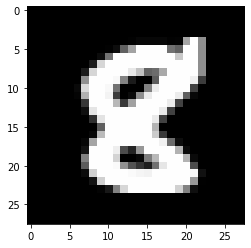

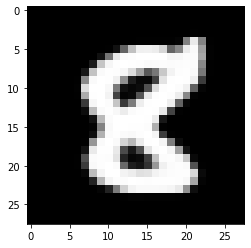

In [20]:
random_label = np.random.randint(0,9999)
img_sample = x_test[random_label,:,:]
plt.imshow(img_sample, cmap='gray');
pred_img = enc_dec.predict(img_sample.reshape((1,28,28,1))) 
plt.figure();
plt.imshow(pred_img.reshape(28,28,1), cmap='gray');


At this point, all we need is to add a dense layer with 10 outputs (the number of classes) to the encoder. 

In [21]:
dense_encoder = Sequential()
dense_encoder.add(Flatten(input_shape = encoder_out_dim ))
dense_encoder.add(Dense(10,activation = 'softmax'))
dense_encoder.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                62730     
Total params: 62,730
Trainable params: 62,730
Non-trainable params: 0
_________________________________________________________________


The weights of the encoder are frozen. The training will affect only the dense layer. 

In [22]:
encoder.trainable = False
labeler = Sequential([encoder, dense_encoder])
labeler.summary()
labeler.compile(optimizer='nadam', loss = 'categorical_crossentropy', metrics=['CategoricalAccuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 7, 7, 128)         92672     
_________________________________________________________________
sequential_4 (Sequential)    (None, 10)                62730     
Total params: 155,402
Trainable params: 62,730
Non-trainable params: 92,672
_________________________________________________________________


Now we train the resulting network `labeler` on the 1% data that has labels.

In [23]:
# train the last layer only on the available labels
labeler.fit(x_train_labeled,y_train_cat_labeled, epochs=1000,validation_split=0.2, callbacks=[es])

Epoch 1/1000
15/15 [==============================] - 0s 22ms/step - loss: 1.4115 - categorical_accuracy: 0.5958 - val_loss: 1.0105 - val_categorical_accuracy: 0.7667
Epoch 2/1000
15/15 [==============================] - 0s 8ms/step - loss: 0.5544 - categorical_accuracy: 0.8625 - val_loss: 0.6940 - val_categorical_accuracy: 0.8333
Epoch 3/1000
15/15 [==============================] - 0s 8ms/step - loss: 0.3428 - categorical_accuracy: 0.9208 - val_loss: 0.5902 - val_categorical_accuracy: 0.8583
Epoch 4/1000
15/15 [==============================] - 0s 7ms/step - loss: 0.2517 - categorical_accuracy: 0.9417 - val_loss: 0.5248 - val_categorical_accuracy: 0.8833
Epoch 5/1000
15/15 [==============================] - 0s 7ms/step - loss: 0.1869 - categorical_accuracy: 0.9583 - val_loss: 0.5091 - val_categorical_accuracy: 0.8583
Epoch 6/1000
15/15 [==============================] - 0s 8ms/step - loss: 0.1478 - categorical_accuracy: 0.9771 - val_loss: 0.4967 - val_categorical_accuracy: 0.8750
Epo

Training will stop quickly due to the low number of data points. The categorical accuracy on validation data is around 85%. Keep in mind that we used 1% to train this network, and 20% of that data was used for validation. This means that we achieved 85% accuracy using 0.8% of labels!  
Let's evaluate the label generator on the test data, and the real training labels.

In [24]:
labeler.evaluate(x_test,y_test_cat)

313/313 [==============================] - 1s 4ms/step - loss: 0.3915 - categorical_accuracy: 0.8781


[0.39149120450019836, 0.8780999779701233]

In [25]:
labeler.evaluate(x_train,y_train_cat)

1875/1875 [==============================] - 7s 4ms/step - loss: 0.4179 - categorical_accuracy: 0.8721


[0.4178599417209625, 0.8720999956130981]

The results are similar: around 88%. Before we use this new labels, let's make a visual comparison with real labels.

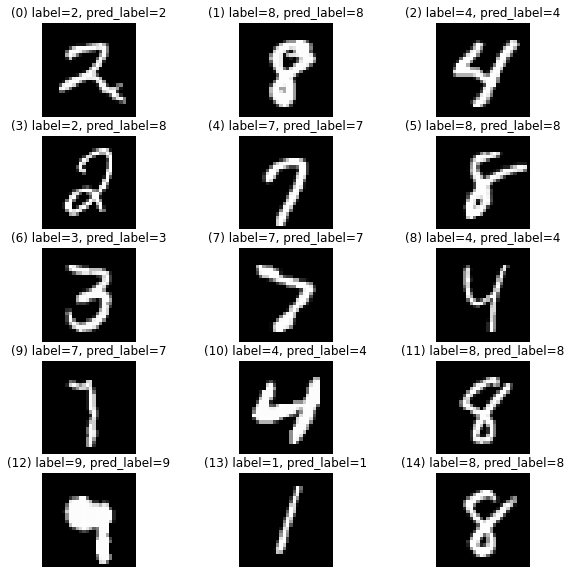

In [26]:
# a test on random images
random_labels = np.random.randint(0,9999,15)
img_samples = x_test[random_labels,:,:,:]
label_samples = y_test[random_labels]
predicted_labels = labeler.predict(img_samples)
plt.figure(figsize=(10, 10));
for i in range(15):
    plt.subplot(5,3,i+1)
    pred_label = np.argmax(predicted_labels[i])+1
    image = img_samples[i]
    plt.imshow(image, cmap='gray');
    plt.title('({}) label={}, pred_label={}'.format(i,label_samples[i],np.argmax(predicted_labels[i])));
    plt.axis('off');


## Random forest classifier training using generated labels

New labels are generated using the network, and used to train a random forest classifier.

In [27]:
new_labels = np.round(labeler.predict(x_train_unlabeled))

In [28]:
# train a classifier using the new labeled data
classifier_generated_labels = clf()
classifier_generated_labels.fit(x_train.reshape(-1,28*28),np.concatenate((y_train_cat_labeled,new_labels)))


RandomForestClassifier()

After the training step, we evaluate the accuracy of the classifier on unseen data (test data).

In [29]:
# score on the test labels
classifier_generated_labels.score(x_test.reshape(-1,28*28),y_test_cat)

0.8107

81% of accuracy! using less than 1% of labels. This technique improved the quality of prediction from 47% to 81%, that's +73%.  
One might wonder about the usefulness of training a random forest on generated labels while we already have a label generation procedure that shows good performances? There are multiple reasons in fact:
- To have a fair comparison, we had to compare similar classification architectures.
- Neural networks are not always an option, because of their complex implementation. 

# Conclusions and future work

In this article, we designed and validated an autoencoder-based label generation method. To confirm the efficiency of this design, we tested on MNIST dataset with only 1% training labels. We achieved 81% accuracy, using a random forest classification.  
The encoder was based on convolutional neural networks. This architecture is used widely in computer vision problems.  
For the sake of simplicity, we didn't perform any hyperparameter tuning. This allowed us to make a fair comparison between all the scenarios.  
This work was a simple application of unsupervised learning techniques, applied to supervised training.  
In a future article, more details of the implementation of convolution will be discussed. We will consider other classification/regression problems involving regular feedforward networks and recurrent neural nets.    